# Lab 3 - Recommendor System

- Scott Gozdzialski
- Adam Baca
- Zoheb Allam
- Ethan Graham

The dataset can be found here http://www2.informatik.uni-freiburg.de/~cziegler/BX/

### Business Understanding 1

Today, businesses rely on different types of information depending on the sector they operate in. A business that focuses on retail customer sales is different than a business that depends on income from services provided.  Regardless of the type of business being run, customer lifetime value, customer retention, is an essential component of a successful business model. Our selected data focuses on the book market and is most relevant to that of a book store.  Our model processes a list of over a million customer ratings for what is evidently a vast majority of the most popular titles.  The customers who have rated books will most likely return; so, we will be building a recommender system based upon their ratings. Customers that have made the initial investment in the system are more likely to return if we recommend new books that would interest them. We can also use the system to attract new customers if we are able to recommend titles that customers would most be interested in reading. 

Recommender systems are an important part of business today, as they can help retain current customers and can attract new customers if the recommendations are more relevant and accurate than the competition. Our recommender system can be used for more than just books. In any industry where customers rate the products or service of businesses can benefit from recommender systems.


In [1]:
import graphlab as gl
import numpy as np
import pandas as pd
from __future__ import print_function

## Data Understanding  1 - Meaning

We will be using as list of book ratings from http://www2.informatik.uni-freiburg.de/~cziegler/BX/ website.  The ratings are stored in multiple files. The one we will be focusing on is BX-Books-Ratings. The different files are stored as CSV files, but they are separated with semicolons which causes errors when trying to work with the data as a CSV. We did some very minor clean up with MS Excel, which is not shown here.  In Excel, we separated the files in to a true CSV by changing the delimiter and dropping records that were captured erroneously during collection. Also in Excel, we took wrote a simple function to match and replace the ISBN of the books with the book title. The result was a source file and recommender system results that are more human readable. After this cleanup we ended up with approximately 900K records.  We will now start are cleanup with pandas.

The rating system is a ten-point system between 1 and 10 with 0 meaning the book was read but not rated.  The records with a zero will be first dropped since they do not represent user ratings in a true sense.

In [2]:
path = "DataMiningFall17\\UserReviewTitle.csv"

df = pd.read_csv('C:\\Users\\adamg_000\\Documents\\GitHub\\DataMiningFall17\\UserReviewTitle.csv',sep = ",")

First we want to see what we are looking at in the dataframe we have loaded.

In [3]:
df = df[df.rating != 0]
df.describe

<bound method DataFrame.describe of             id  rating                                              title
2            8       5                                       Clara Callan
5            8       7                      Goodbye to the Buttermilk Sky
7            8       5                                           Jane Doe
8            8       6  More Cunning Than Man: A Social History of Rat...
12           8       5                                 The Middle Stories
14           8       6       The Witchfinder (Amos Walker Mystery Series)
17           8       5            Where You'll Find Me: And Other Stories
18           9       6               Beloved (Plume Contemporary Fiction)
22          12      10  If I'd Known Then What I Know Now: Why Not Lea...
23          14       6                           Flood : Mississippi 1927
24          14       5  Mary-Kate &amp; Ashley Switching Goals (Mary-K...
25          14       5                       Tell Me This Isn't Happening
27

We see that we have three different columns. Df.describe shows four, the first is the row count.

Next we have

- id : This is the user Id for the user that rated the book.
- rating :  This is the rating the user gave the book.
- title : This is the book title.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351862 entries, 2 to 941139
Data columns (total 3 columns):
id        351862 non-null int64
rating    351862 non-null int64
title     351862 non-null object
dtypes: int64(2), object(1)
memory usage: 10.7+ MB


The data was loaded properly.  Id and rating are integers, while title is an object.  The only change I would think to make is change Id to an object since there is no relationship among users.

Next, we are going to parse down the dataframe from 941K records. 

The first cut will be to drop any title that is rated less than 10 times.  Fifteen was chosen because with  such a large dataset to start with we are looking for the items with the strongest response to start.  If 10 leaves us with a weak result we will change our search criteria.

This will be acheived by grouping the dataframe by title.  Any title with more than 10 counts on their group will be kept.  

******** admin note we will not describe how we parse down the df unless it is different from the above.

In [5]:
df2 = df.groupby('title').filter(lambda x: len(x) >= 10)

In [6]:
df2.shape


(142317, 3)

We end up with over 142K records, so the next step is to parse the dataframe down by dropping any record of any user who has not rated at least 5 books.  This will leave us with books rated 10 times or more by users who have rated at least 5 books. This will give a strong correlation to use for our recommender system.

In [7]:
df3 = df2.groupby('id').filter(lambda x: len(x) >= 5)

In [8]:
df3.shape

(94737, 3)

We end up with 94K records for our reommender sytsem.  This is still a very strong number, we have books rated over 10 times each and users who have rated books 5 times or more.  

## Data Understanding 2 - Visualization
We will look at the different ratings to see what the distribution is of our final dataframe.  We are looking for anything odd, like if all the ratings seem excessively high we will have to include more ratings in the dataframe.  

We will not be looking at title beause it is an object and will not work; also, we tried to count the titles and display the different counts and it maxxed out memory usage and crashed the computer. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001B78F390>]], dtype=object)

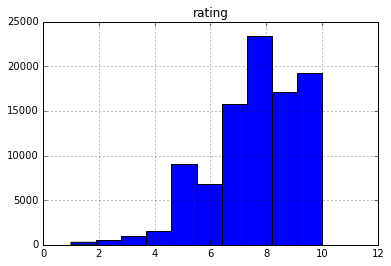

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
df3.hist(column='rating')

The rating distribution does not look bad. All ratings are used, and, as is, they are close to a normal distribution.  They are alittle sckewed, but that will not affect our recommender system.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001B6E4DD8>]], dtype=object)

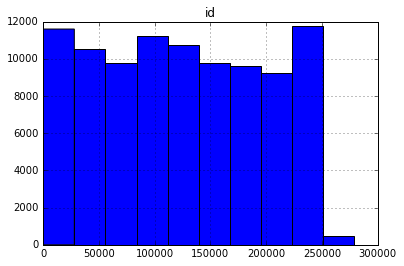

In [10]:
df3.hist(column='id')

We are looking to see if there are any users who have a higher number of ratings than anyone else. This can cause some issues with the recommender system.  There are no good groups of users that have a higher or lower rating than the rest. The lower bar on the right is beacuse the graph is bucketted.  There are far fewer users in the last bucket than the other buckets causing the lower bar.


## Model and Evaluation 1 - Train and adjust

We will be using graphlab to build our recommender system.  We looked at many ways to run our test/train setup, after looking at doing a 60/40 split or a cross-validation, we chose 60/40 split.  This is because we tried the 5-fold cross validation and crashed our computer again.

We are now ready to load our pandas dataframe into a graphlab SFrame. Then we will run a test model to see the results.

In [11]:
data = gl.SFrame(df3)

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\ADAMG_~1\AppData\Local\Temp\graphlab_server_1512956667.log.0


This non-commercial license of GraphLab Create for academic use is assigned to agbaca@smu.edu and will expire on December 10, 2018.


In [12]:
model = gl.recommender.create(data, user_id="id", item_id="title", target="rating")
results = model.recommend(users=None, k=5)
model.save("my_model")

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 94737 observations with 5913 users and 5168 items.

Data prepared in: 0.18313s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11842 / 94737 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 4.09402                                  |

| 5       | 0.0488281         | 4.3747                                   |

| 6       | 0.0244141         | 4.74884                                  |

| 7       | 0.012207          | 5.14138                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 4.09402                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 6.15939           | 1.77247               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 153.108ms    | 5.73099           | 1.78634               | 0.0976562   |

| 2       | 275.195ms    | 5.26998           | 1.7351                | 0.0580668   |

| 3       | 397.282ms    | 4.73819           | 1.57964               | 0.042841    |

| 4       | 501.36ms     | 4.16839           | 1.4127                | 0.0345267   |

| 5       | 613.436ms    | 3.64808           | 1.25543               | 0.029206    |

| 6       | 727.518ms    | 3.20712           | 1.11943               | 0.0254734   |

| 10      | 1.05s        | 2.18557           | 0.803022              | 0.017366    |

| 11      | 1.15s        | 2.03092           | 0.756579              | 0.016168    |

| 20      | 1.87s        | 1.34086           | 0.550918              | 0.0103259   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.09009

Final training RMSE: 0.421369

recommendations finished on 1000/5913 queries. users per second: 18170.9

recommendations finished on 2000/5913 queries. users per second: 17845.4

recommendations finished on 3000/5913 queries. users per second: 16293.3

recommendations finished on 4000/5913 queries. users per second: 16248.8

recommendations finished on 5000/5913 queries. users per second: 16117.9

In [13]:
results

id,title,score,rank
114,Mystic River,9.57820114311,1
114,The Da Vinci Code,9.03024634537,2
114,Digital Fortress : AThriller ...,8.80927762207,3
114,The Lovely Bones: A Novel,8.80343779739,4
114,Deception Point,8.66140076336,5
243,A Prayer for Owen Meany,10.420504896,1
243,Red Dragon,9.54952749428,2
243,The Red Tent (BestsellingBacklist) ...,9.49726089653,3
243,Wish You Well,9.38630470451,4
243,The Lovely Bones: A Novel,9.24060568031,5


In [14]:
data.head()

id,rating,title
114,8,A Kiss Remembered
114,10,Angels &amp; Demons
114,9,Dead Aim
114,9,The Alibi
114,9,The Beach House
114,8,The Short Forever
243,7,A Map of the World
243,5,A Monk Swimming
243,7,A Painted House
243,5,Chicken Soup for the Soul(Chicken Soup for the ...


Everything looks solid with the recommender system.  We see above the actual head of the SFrame.  We can see it is different than the recommender systems results.  We can also see because we parsed the data down so much there are strong results in the recommender system. 

## Model and Evaluation 2 - Evaluate and compare 

Which books have simialar ratings by user?  We will check this by doing a comparision of the items 

In [15]:
item_item = gl.recommender.item_similarity_recommender.create(data, 
                                  user_id="id", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k=3,
                                  similarity_type="cosine")

results = item_item.get_similar_items(k=3)
results.head()

Recsys training: model = item_similarity

Preparing data set.

Data has 94737 observations with 5913 users and 5168 items.

Data prepared in: 0.132096s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1ms                            | 33.75      |

| 2.001ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 56.041ms                            | 0                | 0               |

| 298.21ms                            | 100              | 5168            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.308217s

title,similar,score,rank
A Kiss Remembered,Skyward,0.261462032795,1
A Kiss Remembered,Due di due (Bestsellers),0.252216637135,2
A Kiss Remembered,El Alquimista,0.252216637135,3
Angels &amp; Demons,Digital Fortress : AThriller ...,0.233063042164,1
Angels &amp; Demons,The Da Vinci Code,0.23293530941,2
Angels &amp; Demons,Deception Point,0.204197227955,3
Dead Aim,Lost Light,0.289388597012,1
Dead Aim,Deadly Grace,0.285212695599,2
Dead Aim,Whisper of Evil (Hooper,0.271470725536,3
The Alibi,The Switch,0.218910515308,1


We can see the similiarity matrix is not to good.  Our similiarity scores are low, we need to find a way to increase them. Lets try the Jaccard distance to see if we get better results.

In [16]:
item_item = gl.recommender.item_similarity_recommender.create(data, 
                                  user_id="id", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k=3,
                                  similarity_type="jaccard")

results = item_item.get_similar_items(k=3)
results.head()

Recsys training: model = item_similarity

Preparing data set.

Data has 94737 observations with 5913 users and 5168 items.

Data prepared in: 0.125091s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 999us                          | 16.75      |

| 2ms                            | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 47.032ms                            | 0                | 0               |

| 280.198ms                           | 100              | 5168            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.295208s

title,similar,score,rank
A Kiss Remembered,Breakfast in Bed,0.157894730568,1
A Kiss Remembered,The Widow's Kiss,0.153846144676,2
A Kiss Remembered,The Ghost Next Door(Goosebumps ...,0.153846144676,3
Angels &amp; Demons,The Da Vinci Code,0.121287107468,1
Angels &amp; Demons,Digital Fortress : AThriller ...,0.107142865658,2
Angels &amp; Demons,Deception Point,0.0883721113205,3
Dead Aim,Lost Light,0.156862735748,1
Dead Aim,Whisper of Evil (Hooper,0.125,2
Dead Aim,Between Friends,0.125,3
The Alibi,The Switch,0.0833333134651,1


The Jaccard distance was worse.  We will be using the cosine distance. Lets try using our test train split to see the results.

In [17]:
train, test = gl.recommender.util.random_split_by_user(data, user_id="id", item_id="title",item_test_proportion=0.4)

In [18]:
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')


item_item = gl.recommender.item_similarity_recommender.create(train, 
                                  user_id="id", 
                                  item_id="title", 
                                  target="rating",
                                  only_top_k=5,
                                  similarity_type="cosine")

rmse_results = item_item.evaluate(test)

Recsys training: model = item_similarity

Preparing data set.

Data has 88650 observations with 5912 users and 5166 items.

Data prepared in: 0.107096s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 981us                          | 16.75      |

| 2.983ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 52.02ms                             | 0                | 0               |

| 301.194ms                           | 100              | 5166            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.309199s


Precision and recall summary statistics by cutoff
+--------+-----------------+-----------------+
| cutoff |  mean_precision |   mean_recall   |
+--------+-----------------+-----------------+
|   1    | 0.0867346938776 | 0.0184027666812 |
|   2    | 0.0739795918367 | 0.0291755318746 |
|   3    |  0.065306122449 | 0.0380853194072 |
|   4    | 0.0566326530612 | 0.0449398548783 |
|   5    | 0.0530612244898 |  0.051889832747 |
|   6    | 0.0501700680272 | 0.0584350073999 |
|   7    | 0.0492711370262 | 0.0656137659154 |
|   8    | 0.0469387755102 | 0.0687860594261 |
|   9    | 0.0436507936508 | 0.0716516975915 |
|   10   | 0.0413265306122 | 0.0744230623449 |
+--------+-----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 7.974462132815181)

Per User RMSE (best)
+--------+-------+------+
|   id   | count | rmse |
+--------+-------+------+
| 200568 |   1   | 3.0  |
+--------+-------+------+
[1 rows x 3 columns]


Per User RMSE (worst)
+--------+-------+------+
|   i

Our precision, recall and RMSE are not great.  Lets try a user-item matrix to see if there is an improvement.

In [19]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="id", 
                                  item_id="title", 
                                  target="rating")

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 88650 observations with 5912 users and 5166 items.

Data prepared in: 0.134095s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11081 / 88650 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 4.06581                                  |

| 5       | 0.0488281         | 4.37653                                  |

| 6       | 0.0244141         | 4.77362                                  |

| 7       | 0.012207          | 5.1826                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 4.06581                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 6.16847           | 1.77377               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 101.072ms    | 5.75029           | 1.78825               | 0.0976562   |

| 2       | 186.133ms    | 5.2664            | 1.72994               | 0.0580668   |

| 3       | 271.193ms    | 4.84885           | 1.61072               | 0.042841    |

| 4       | 351.25ms     | 4.33463           | 1.46707               | 0.0345267   |

| 5       | 432.307ms    | 3.83491           | 1.31524               | 0.029206    |

| 6       | 514.366ms    | 3.40826           | 1.18192               | 0.0254734   |

| 11      | 897.639ms    | 2.16787           | 0.791518              | 0.016168    |

| 25      | 1.91s        | 1.20245           | 0.499791              | 0.00873464  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.13179

Final training RMSE: 0.426321


Precision and recall summary statistics by cutoff
+--------+-----------------+------------------+
| cutoff |  mean_precision |   mean_recall    |
+--------+-----------------+------------------+
|   1    | 0.0295918367347 | 0.00624416369558 |
|   2    | 0.0224489795918 |  0.009149754298  |
|   3    | 0.0248299319728 | 0.0165121262759  |
|   4    | 0.0232142857143 | 0.0201473202108  |
|   5    | 0.0208163265306 |  0.023726766275  |
|   6    | 0.0200680272109 | 0.0268828451929  |
|   7    | 0.0198250728863 | 0.0293911031654  |
|   8    | 0.0195153061224 | 0.0327831085718  |
|   9    | 0.0191609977324 | 0.0360525171298  |
|   10   | 0.0186734693878 | 0.0385674830313  |
+--------+-----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 2.856454147885199)

Per User RMSE (best)
+-------+-------+-----------------+
|   id  | count |       rmse      |
+-------+-------+-----------------+
| 75330 |   1   | 0.0183120725522 |
+-------+-------+-----------------+
[1 rows x 3 

So lets try some different settings.

In [20]:
rec1 = gl.recommender.ranking_factorization_recommender.create(train, 
                                  user_id="id", 
                                  item_id="title", 
                                  target="rating",
                                  num_factors=16,                 # override the default value
                                  regularization=1e-02,           # override the default value
                                  linear_regularization = 1e-3)   # override the default value

rmse_results = rec1.evaluate(test)

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 88650 observations with 5912 users and 5166 items.

Data prepared in: 0.122088s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 16       |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.001    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11081 / 88650 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0830819         | Not Viable                               |

| 1       | 0.0207705         | 5.58801                                  |

| 2       | 0.0103852         | 5.70408                                  |

| 3       | 0.00519262        | 5.83009                                  |

| 4       | 0.00259631        | 5.92758                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0207705         | 5.58801                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 6.16847           | 1.77377               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 126.09ms     | DIVERGED          | DIVERGED              | 0.0207705   |

| RESET   | 180.133ms    | 6.16805           | 1.77377               |             |

| 1       | 289.206ms    | DIVERGED          | DIVERGED              | 0.0103852   |

| RESET   | 341.242ms    | 6.16817           | 1.77377               |             |

| 1       | 449.32ms     | DIVERGED          | DIVERGED              | 0.00519262  |

| RESET   | 505.36ms     | 6.16828           | 1.77377               |             |

| 1       | 577.411ms    | 5.9689            | 1.73726               | 0.00259631  |

| 2       | 674.48ms     | 5.77362           | 1.70697               | 0.000786372 |

| 3       | 762.544ms    | 5.7376            | 1.7016                | 0.000463357 |

| 4       | 838.597ms    | 5.72399           | 1.69845               | 0.000328444 |

| 5       | 920.655ms    | 5.71499           | 1.69672               | 0.000254378 |

| 6       | 1.08s        | 5.7109            | 1.69517               | 0.00020757  |

| 11      | 1.67s        | 5.70013           | 1.69141               | 0.000108106 |

| 22      | 2.54s        | 5.69641           | 1.68793               |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 5.69721

Final training RMSE: 1.68731


Precision and recall summary statistics by cutoff
+--------+-----------------+------------------+
| cutoff |  mean_precision |   mean_recall    |
+--------+-----------------+------------------+
|   1    | 0.0204081632653 | 0.00206968904661 |
|   2    |  0.019387755102 | 0.00469242839674 |
|   3    | 0.0180272108844 | 0.0072778082721  |
|   4    | 0.0163265306122 | 0.00969686831095 |
|   5    | 0.0148979591837 | 0.0108425680198  |
|   6    | 0.0144557823129 | 0.0127396008703  |
|   7    | 0.0137026239067 |  0.014101188639  |
|   8    | 0.0142857142857 | 0.0173067325569  |
|   9    | 0.0160997732426 | 0.0220086748212  |
|   10   |  0.015306122449 | 0.0227947037463  |
+--------+-----------------+------------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 1.6983047190211802)

Per User RMSE (best)
+--------+-------+----------------+
|   id   | count |      rmse      |
+--------+-------+----------------+
| 232929 |   1   | 0.212471082636 |
+--------+-------+----------------+
[1 rows x 3

Everything is looking way better with with user-item model.  We will contue using this model.

## Model and Evaluate 3 - Visualize results

The distributions, means, and standard deviations look very similar to each other.

How well did we capture the distribution of the rating in particular?

In [21]:
rmse_results.viewkeys()

dict_keys(['rmse_by_user', 'precision_recall_overall', 'rmse_by_item', 'precision_recall_by_user', 'rmse_overall'])

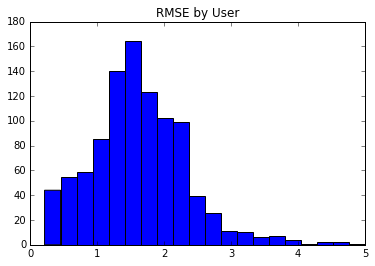

In [22]:
rmsevals = rmse_results['rmse_by_user']['rmse']
rmsevals = rmsevals[rmse_results['rmse_by_user']['count']]

plt.hist(rmsevals,bins=20)
plt.title('RMSE by User')
plt.show()

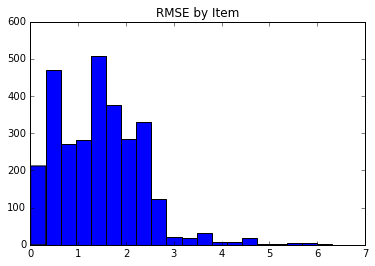

In [23]:
rmsevals = rmse_results['rmse_by_item']['rmse']
rmsevals = rmsevals[rmse_results['rmse_by_item']['count']]

plt.hist(rmsevals,bins=20)
plt.title('RMSE by Item')
plt.show()

We can see we have a solid low RMSE for our model.  This is in both users and titles.  This model looks good.

Is it actually better than the previous item-item matrix?  Lets compare.

In [24]:
comparison = gl.recommender.util.compare_models(test, [item_item, rec1])

PROGRESS: Evaluate model M0

Precision and recall summary statistics by cutoff
+--------+-----------------+-----------------+
| cutoff |  mean_precision |   mean_recall   |
+--------+-----------------+-----------------+
|   1    | 0.0867346938776 | 0.0184027666812 |
|   2    | 0.0739795918367 | 0.0291755318746 |
|   3    |  0.065306122449 | 0.0380853194072 |
|   4    | 0.0566326530612 | 0.0449398548783 |
|   5    | 0.0530612244898 |  0.051889832747 |
|   6    | 0.0501700680272 | 0.0584350073999 |
|   7    | 0.0492711370262 | 0.0656137659154 |
|   8    | 0.0468112244898 | 0.0684459233717 |
|   9    |  0.043537414966 | 0.0713115615371 |
|   10   | 0.0413265306122 | 0.0744230623449 |
+--------+-----------------+-----------------+
[10 rows x 3 columns]

('\nOverall RMSE: ', 7.974462132815181)

Per User RMSE (best)
+--------+-------+------+
|   id   | count | rmse |
+--------+-------+------+
| 200568 |   1   | 3.0  |
+--------+-------+------+
[1 rows x 3 columns]


Per User RMSE (worst)
+--

We can see the vast different in the two models.  The User-Item matrix is better in every facet than the Item-Item matrix.  So, we will be sticking with the User-Item matrix.

## Modeling and Evaluation 4 - Summarize the Ramifications.

We have built three different models for our recommender system.  We have built a item-item matrix, a user-user matrix, and finally a User-Item matrix. We test all three models with precision, recall, and RMSE.  As we built the different models we checked the results.  Each iteration of the model was better than the last one. Between the Item-Item to the User-Item we can see that every portion of the model improved.


## Deployment

The model came out came out pretty good in the end.  We achieved the results in our target range.  We would like a stronger precision.  It would take a more in depth look at the data to increase it.  This might be the best this dataset can give us.

To deploy our model, we would use it in a book store, both online and in-store.  For in-store use we would use a kiosk where users can input and rate books they have read and receive recommendations of books in stock to read.  

With some minor changes this model can possibly work with other simple recommender systems, like movies, television shows, etc.

For the best accuracy users need to periodically collect/provide recommendation/rating data from other users to add to the dataset and capture new releases.

The model should be updated periodically, but since books are not released too often there is no need for constant updates. We recommend updating the model either weekly or semi-weekly.

## Exceptional Work

Don't have anything for this section.  Looking into building an SGraph of users with ratings similar to each other but the data is not in the correct format.